In [1]:
import pandas as pd
import numpy as np
import time

from sklearn import datasets, linear_model
# from genetic_selection import GeneticSelectionCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate, KFold, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, accuracy_score
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt

ModuleNotFoundError: ignored

## 1. Import Data

In [ ]:
patient_df = pd.read_csv('/home/e0205142/MIMIC_assignment2/data/patientfinal_2.csv')
patient_df.head(n=5)

,stay_id,icu_intime,aki_charttime,adm_age,weight,age_score,myocardial_infarct,congestive_heart_failure,peripheral_vascular_disease,cerebrovascular_disease,...,charlson_comorbidity_index,ace,arb,diuretic,immunosuppressant,increase_bp,infection,nsaid,opioid,reduce_bp
0,30001535,11/17/2177 20:30,11/17/2177 23:51,69,80.0,3,0,0,0,1,...,6,0,0,0,0,1,1,0,0,0
1,30002052,12/30/2180 5:24,12/31/2180 10:00,63,56.7,3,0,0,0,0,...,9,0,0,0,1,0,1,0,0,1
2,30002095,7/30/2190 14:35,NaN,63,106.9,3,1,1,1,0,...,7,1,0,1,0,0,0,0,0,1
3,30002198,1/4/2145 22:15,NaN,64,62.7,3,0,0,0,0,...,5,0,0,0,0,1,0,0,1,0
4,30002528,8/1/2177 22:56,NaN,49,118.0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


In [ ]:
patient_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19375 entries, 0 to 19374
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   stay_id                      19375 non-null  int64  
 1   icu_intime                   19375 non-null  object 
 2   aki_charttime                10106 non-null  object 
 3   adm_age                      19375 non-null  int64  
 4   weight                       19253 non-null  float64
 5   age_score                    19375 non-null  int64  
 6   myocardial_infarct           19375 non-null  int64  
 7   congestive_heart_failure     19375 non-null  int64  
 8   peripheral_vascular_disease  19375 non-null  int64  
 9   cerebrovascular_disease      19375 non-null  int64  
 10  dementia                     19375 non-null  int64  
 11  chronic_pulmonary_disease    19375 non-null  int64  
 12  rheumatic_disease            19375 non-null  int64  
 13  peptic_ulcer_dis

## 2. Fix the dtype

In [ ]:
patient_df['stay_id'] = patient_df['stay_id'].astype('object') # patient id: from int to string
patient_df.iloc[:, 5:] = patient_df.iloc[:, 5:].apply(lambda x: x.astype('category')) # from int to category

In [ ]:
# change to 'datatime' formart
patient_df['icu_intime'] = pd.to_datetime(patient_df['icu_intime'])
patient_df['aki_charttime'] = pd.to_datetime(patient_df['aki_charttime'])

In [ ]:
# check the timestamps
patient_df[['icu_intime', 'aki_charttime']].head(n=5)

,icu_intime,aki_charttime
0,2177-11-17 20:30:00,2177-11-17 23:51:00
1,2180-12-30 05:24:00,2180-12-31 10:00:00
2,2190-07-30 14:35:00,NaT
3,2145-01-04 22:15:00,NaT
4,2177-08-01 22:56:00,NaT


In [ ]:
# AKI onset time gap (round to hour)
patient_df['time_delta'] = (patient_df['aki_charttime'] - patient_df['icu_intime']).astype('timedelta64[ns]').round('h')

In [ ]:
# AKI binary label: yes or no
patient_df['AKI'] = np.where(patient_df['time_delta'].isnull(), 0, 1)
patient_df['AKI'] = patient_df['AKI'].astype('category')
patient_df['AKI'].value_counts()

1    10106
0     9269
Name: AKI, dtype: int64

In [ ]:
# check the feature properties
## 1. continuous variables
patient_df.describe(include = ['float64','timedelta64[ns]'])

,weight,time_delta
count,19253.000000,10106
mean,81.295055,0 days 16:07:24.567583613
std,25.591159,0 days 10:24:36.243541228
min,1.000000,0 days 00:00:00
25%,65.500000,0 days 08:00:00
50%,78.200000,0 days 13:00:00
75%,93.100000,0 days 22:00:00
max,850.000000,2 days 00:00:00


In [ ]:
## 2. categorical variables
patient_df.describe(include = ['category'])

,age_score,myocardial_infarct,congestive_heart_failure,peripheral_vascular_disease,cerebrovascular_disease,dementia,chronic_pulmonary_disease,rheumatic_disease,peptic_ulcer_disease,mild_liver_disease,...,ace,arb,diuretic,immunosuppressant,increase_bp,infection,nsaid,opioid,reduce_bp,AKI
count,19375,19375,19375,19375,19375,19375,19375,19375,19375,19375,...,19375,19375,19375,19375,19375,19375,19375,19375,19375,19375
unique,5,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
top,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,1
freq,8504,15790,13991,17183,16094,18289,14670,18672,18873,17560,...,18064,18794,14880,16501,11924,11194,12654,11093,10872,10106


## 3. Outliers and missing values

In [ ]:
patient_df['weight'] = patient_df['weight'].mask(patient_df['weight'] > 250, np.nan)

check NAs

In [ ]:
patient_df.isnull().sum()

stay_id                           0
icu_intime                        0
aki_charttime                  9269
adm_age                           0
weight                          130
age_score                         0
myocardial_infarct                0
congestive_heart_failure          0
peripheral_vascular_disease       0
cerebrovascular_disease           0
dementia                          0
chronic_pulmonary_disease         0
rheumatic_disease                 0
peptic_ulcer_disease              0
mild_liver_disease                0
diabetes_without_cc               0
diabetes_with_cc                  0
paraplegia                        0
renal_disease                     0
malignant_cancer                  0
severe_liver_disease              0
metastatic_solid_tumor            0
aids                              0
charlson_comorbidity_index        0
ace                               0
arb                               0
diuretic                          0
immunosuppressant           

### kNN imputation for missing values

In [ ]:
scaler = MinMaxScaler()
patient_df[['adm_age', 'weight']] = scaler.fit_transform(patient_df[['adm_age', 'weight']])

In [ ]:
feature_name = patient_df.iloc[:, 3:-2].keys()
print(feature_name)

Index(['adm_age', 'weight', 'age_score', 'myocardial_infarct',
       'congestive_heart_failure', 'peripheral_vascular_disease',
       'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease',
       'rheumatic_disease', 'peptic_ulcer_disease', 'mild_liver_disease',
       'diabetes_without_cc', 'diabetes_with_cc', 'paraplegia',
       'renal_disease', 'malignant_cancer', 'severe_liver_disease',
       'metastatic_solid_tumor', 'aids', 'charlson_comorbidity_index', 'ace',
       'arb', 'diuretic', 'immunosuppressant', 'increase_bp', 'infection',
       'nsaid', 'opioid', 'reduce_bp'],
      dtype='object')


In [ ]:
X = patient_df.iloc[:, 3:-2]
y = patient_df['AKI']

In [ ]:
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
# fit on the dataset
imputer.fit(X)

KNNImputer()

In [ ]:
# transform the dataset
X = imputer.transform(X)

In [ ]:
# double check if there is missing values left
print('Missing: %d' % sum(np.isnan(X).flatten()))

Missing: 0


## 4. Baseline without feature selection

### Data split

In [ ]:
print(X.shape)
print(y.shape)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

(19375, 30)
(19375,)


### Train and Test

In [ ]:
models = [
          ('LR', LogisticRegression(class_weight = 'balanced', solver='sag', max_iter=1000)), 
          ('DT', DecisionTreeClassifier(class_weight = 'balanced')),
          ('RF', RandomForestClassifier(class_weight = 'balanced')),
          ('AdaBoost', AdaBoostClassifier(n_estimators=1000)),
          ('GBM', GradientBoostingClassifier(n_estimators=1000)),
          ('SVM', SVC(probability=True, class_weight = 'balanced'))
        ]

# Parameter tuning grids-------------------------
LR_params = [{'C': [ 10, 1.0, 0.1, 0.01]}]
DT_params = [{}]
RF_params = [{'n_estimators': [50, 100, 500]}]
Gradient_params = [{'learning_rate': [0.001, 0.01, 0.1], 'n_estimators': [500, 1000], 'subsample': [0.5, 0.7, 1.0], 'max_depth': [3, 7, 9]}]
Ada_params = [{'learning_rate': [0.001, 0.01, 0.1], 'n_estimators': [500, 1000], 'base_estimator': [DecisionTreeClassifier(max_depth=1, class_weight = 'balanced'), DecisionTreeClassifier(max_depth=5, class_weight = 'balanced')]}]
SVM_params =[{'kernel': ['linear', 'poly', 'rbf'], 'C': [100, 10, 1.0, 0.1, 0.001]}]

my_grid ={'LR': LR_params,
         'DT': DT_params,
         'RF': RF_params,
         'AdaBoost': Ada_params,
         'GBM': Gradient_params,
         'SVM': SVM_params}

# Model Training and Evaluation-------------------
train_acc, test_acc, train_auc, test_auc = [], [], [], []
names = []
runtimes = []
best_params = []
clfs = []

for name, model in models:
    start_time = time.time()
    
    clf = GridSearchCV(model, my_grid[name], cv = 5, scoring='roc_auc', n_jobs=10)
    clf.fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    y_train_score = clf.predict_proba(X_train)
    y_test_pred = clf.predict(X_test)
    y_test_score = clf.predict_proba(X_test)
    #cv_results.append(cv_result)
    runtime = (time.time() - start_time)
    
    train_acc.append(balanced_accuracy_score(y_train, y_train_pred))
    test_acc.append(balanced_accuracy_score(y_test, y_test_pred))
    train_auc.append(roc_auc_score(y_train, y_train_score[:, 1]))
    test_auc.append(roc_auc_score(y_test, y_test_score[:, 1]))
    
    best_params.append(clf.best_params_)
    clfs.append(clf)
    
    names.append(name)
    runtimes.append(runtime)
    print("---%s finished in %s seconds ---" % (name, runtime))
    print('>%s: test AUC %.3f' % (name, roc_auc_score(y_test, y_test_score[:, 1])))

scores_df_baseline = pd.DataFrame({'train_acc':train_acc, 
                          'test_acc':test_acc, 
                          'train_auc':train_auc,
                          'test_auc':test_auc, 
                          'runtime(s)':runtimes}, index=names)

---LR finished in 3.813262462615967 seconds ---
>LR: test AUC 0.758
---DT finished in 0.3726532459259033 seconds ---
>DT: test AUC 0.599
---RF finished in 14.520545959472656 seconds ---
>RF: test AUC 0.744
---AdaBoost finished in 87.66661429405212 seconds ---
>AdaBoost: test AUC 0.758
---GBM finished in 453.57642674446106 seconds ---
>GBM: test AUC 0.766
---SVM finished in 534.8471908569336 seconds ---
>SVM: test AUC 0.757


## 5. Feature selection

### Permutation scores

In [ ]:
start_time = time.time()

selector = LogisticRegression(class_weight = 'balanced', solver='sag', max_iter=1000)
selector.fit(X_train, y_train)

perm_score = permutation_importance(selector, X_train, y_train, n_repeats=10, random_state=42, n_jobs=5)

print("---Feature selection finished in %s seconds ---" %  (time.time() - start_time))

---Feature selection finished in 61.30062770843506 seconds ---


In [ ]:
sorted_idx = perm_score.importances_mean.argsort() # from low to high
sorted_idx

array([19,  9, 10, 18, 22, 17, 14,  7, 13, 11, 16,  5, 21, 12,  8,  6, 15,
        3,  2, 24, 29, 23, 26, 27, 20, 28,  4,  0, 25,  1])

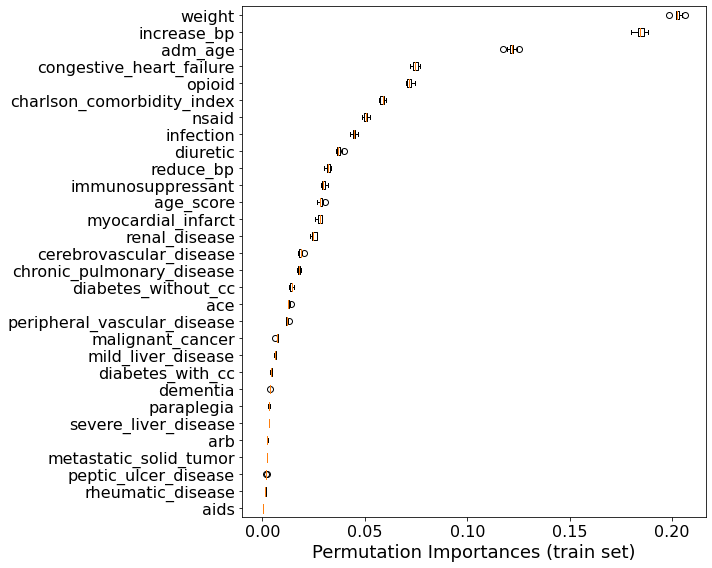

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
ax.boxplot(perm_score.importances[sorted_idx].T, vert=False, labels=feature_name[sorted_idx])
plt.xlabel('Permutation Importances (train set)', fontsize=18)
plt.xticks(fontsize= 16)
plt.yticks(fontsize= 16)
fig.tight_layout()
plt.show()

In [ ]:
# Measuring the performance on validation set with models trained with different number of top k features.

parsi = {}
scoring = {'acc': 'accuracy',
           'auc': 'roc_auc'}

sorted_idx = sorted_idx[::-1]

val_auc = []
val_acc = []

for k in range(len(sorted_idx)):
    subset = X_train[:, sorted_idx[:k+1]]
    selector.fit(subset, y_train)
    
    y_val_pred = selector.predict(X_val[:, sorted_idx[:k+1]])
    y_val_score = selector.predict_proba(X_val[:, sorted_idx[:k+1]])

    #cv_results.append(cv_result)
    runtime = (time.time() - start_time)
    
    val_acc.append(accuracy_score(y_val, y_val_pred))
    val_auc.append(roc_auc_score(y_val, y_val_score[:, 1]))
    

    print("Top",k+1,"is Done")

Top 1 is Done
Top 2 is Done
Top 3 is Done
Top 4 is Done
Top 5 is Done
Top 6 is Done
Top 7 is Done
Top 8 is Done
Top 9 is Done
Top 10 is Done
Top 11 is Done
Top 12 is Done
Top 13 is Done
Top 14 is Done
Top 15 is Done
Top 16 is Done
Top 17 is Done
Top 18 is Done
Top 19 is Done
Top 20 is Done
Top 21 is Done
Top 22 is Done
Top 23 is Done
Top 24 is Done
Top 25 is Done
Top 26 is Done
Top 27 is Done
Top 28 is Done
Top 29 is Done
Top 30 is Done


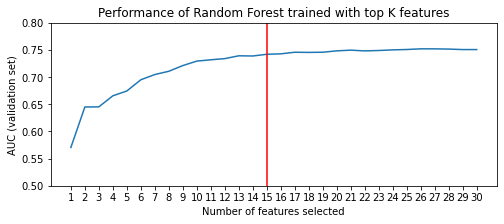

In [ ]:
plt.figure(figsize=[8, 3])
plt.xlabel("Number of features selected")
plt.ylabel("AUC (validation set)")
plt.title("Performance of Random Forest trained with top K features")
plt.plot(range(1,len(feature_name)+1), val_auc)
plt.ylim([0.5, 0.8])
plt.axvline(x=15, c = 'r')
plt.xticks(range(1,len(feature_name)+1))
#plt.legend()
plt.show()

## Model Evaluation

In [ ]:
# Transform the dataset with top 6 features selected
X_train_selected = X_train[:, sorted_idx[::-1][:15]]
X_test_selected = X_test[:, sorted_idx[::-1][:15]]

X_train_selected = X_train[:, sorted_idx[:15]]
X_test_selected = X_test[:, sorted_idx[:15]]

In [ ]:
models = [
          ('LR', LogisticRegression(class_weight = 'balanced', solver='sag', max_iter=1000)), 
          ('DT', DecisionTreeClassifier(class_weight = 'balanced')),
          ('RF', RandomForestClassifier(class_weight = 'balanced')),
          ('AdaBoost', AdaBoostClassifier(n_estimators=1000)),
          ('GBM', GradientBoostingClassifier(n_estimators=1000)),
          ('SVM', SVC(probability=True, class_weight = 'balanced'))
        ]

# Parameter tuning grids-------------------------
LR_params = [{'C': [ 10, 1.0, 0.1, 0.01]}]
DT_params = [{}]
RF_params = [{'n_estimators': [50, 100, 500]}]
Gradient_params = [{'learning_rate': [0.001, 0.01, 0.1], 'n_estimators': [500, 1000], 'subsample': [0.5, 0.7, 1.0], 'max_depth': [3, 7, 9]}]
Ada_params = [{'learning_rate': [0.001, 0.01, 0.1], 'n_estimators': [500, 1000], 'base_estimator': [DecisionTreeClassifier(max_depth=1, class_weight = 'balanced'), DecisionTreeClassifier(max_depth=5, class_weight = 'balanced')]}]
SVM_params =[{'kernel': ['linear', 'poly', 'rbf'], 'C': [100, 10, 1.0, 0.1, 0.001]}]

my_grid ={'LR': LR_params,
         'DT': DT_params,
         'RF': RF_params,
         'AdaBoost': Ada_params,
         'GBM': Gradient_params,
         'SVM': SVM_params}

# evaluate all the models
train_acc, test_acc, train_auc, test_auc = [], [], [], []
names = []
cv_results = []
best_params = []
clfs = []
runtimes = []

for name, model in models:
    start_time = time.time()

    
    clf = GridSearchCV(model, my_grid[name], cv = 5, scoring='roc_auc', n_jobs=10)
    clf.fit(X_train_selected, y_train)

    y_train_pred = clf.predict(X_train_selected)
    y_train_score = clf.predict_proba(X_train_selected)
    y_test_pred = clf.predict(X_test_selected)
    y_test_score = clf.predict_proba(X_test_selected)
    #cv_results.append(cv_result)
    
    train_acc.append(balanced_accuracy_score(y_train, y_train_pred))
    test_acc.append(balanced_accuracy_score(y_test, y_test_pred))
    train_auc.append(roc_auc_score(y_train, y_train_score[:, 1]))
    test_auc.append(roc_auc_score(y_test, y_test_score[:, 1]))
    
    best_params.append(clf.best_params_)
    clfs.append(clf)
    
    names.append(name)
    
    runtime = (time.time() - start_time)
    runtimes.append(runtime)
    print("---%s finished in %s seconds ---" % (name, runtime))
    print('>%s: test AUC %.3f' % (name, roc_auc_score(y_test, y_test_score[:, 1])))


---LR finished in 2.3011276721954346 seconds ---
>LR: test AUC 0.756
---DT finished in 0.3404111862182617 seconds ---
>DT: test AUC 0.599
---RF finished in 13.352301597595215 seconds ---
>RF: test AUC 0.733
---AdaBoost finished in 70.86090087890625 seconds ---
>AdaBoost: test AUC 0.756
---GBM finished in 380.6130516529083 seconds ---
>GBM: test AUC 0.765
---SVM finished in 512.6416466236115 seconds ---
>SVM: test AUC 0.756


In [ ]:
scores_df = pd.DataFrame({'train_acc':train_acc, 
                          'test_acc':test_acc, 
                          'train_auc':train_auc,
                          'test_auc':test_auc, 
                          'runtime(s)': runtimes}, index=names)
print(scores_df)

          train_acc  test_acc  train_auc  test_auc  runtime(s)
LR         0.684334  0.692692   0.750166  0.756105    2.301128
DT         0.999837  0.598639   1.000000  0.598639    0.340411
RF         0.999818  0.673801   1.000000  0.732895   13.352302
AdaBoost   0.688719  0.687321   0.755237  0.756008   70.860901
GBM        0.703108  0.691012   0.780586  0.764879  380.613052
SVM        0.698978  0.690305   0.775168  0.756357  512.641647


In [ ]:
print(scores_df_baseline)

          train_acc  test_acc  train_auc  test_auc  runtime(s)
LR         0.688055  0.695688   0.756060  0.758356    3.813262
DT         0.999837  0.599207   1.000000  0.599355    0.372653
RF         0.999818  0.672762   1.000000  0.744047   14.520546
AdaBoost   0.689599  0.692879   0.759472  0.758339   87.666614
GBM        0.708110  0.690922   0.786898  0.766413  453.576427
SVM        0.702904  0.692557   0.779389  0.756755  534.847191
